# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

***

## Set Up Session

In [1]:
# Configuration:
from traffic_sign_classification.utils.conf import Conf
# Utilities:
from os.path import join, dirname
from datetime import datetime
import time
# ETL:
from traffic_sign_classification.utils.dataset import Dataset
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
# Preprocessing:
from traffic_sign_classification.preprocessors import Preprocessor
# Modeling:
import tensorflow as tf
import tensorflow.contrib.layers as layers
# Visualization:
import matplotlib.pyplot as plt
%matplotlib inline
from traffic_sign_classification.utils.visualization import draw_image_mosaic
from traffic_sign_classification.utils.visualization import draw_label_distributions
from traffic_sign_classification.utils.visualization import draw_top_k

## Load Configuration

In [2]:
conf = Conf('conf/conf.json')

---
## Step 0: Load The Data

In [3]:
# Load dataset:
dataset = Dataset(
    conf.dataset_train,
    conf.dataset_valid,
    conf.dataset_test,
    conf.dataset_label_encoding
)

X_train, y_train = dataset.train["features"], dataset.train["labels"]
X_valid, y_valid = dataset.valid["features"], dataset.valid["labels"]
X_test , y_test  = dataset.test["features"], dataset.test["labels"]

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Below are summary stats for the dataset

### Basic Summary of the Data Set

In [4]:
# Here I have implemented dataset summary as the instance method __str__
print(dataset)

Number of training/validation/testing examples = (34799, 4410, 12630)
Training/validation/testing percentange sizes = (67.13, 8.51, 24.36)
Image data shape = (32, 32, 3)
Number of classes = 43



### Exploratory Visualization of the Dataset

***

Here image mosaicing consisting of 256 random samples from training dataset and label distribution by subset will be provided

#### Image Mosaic

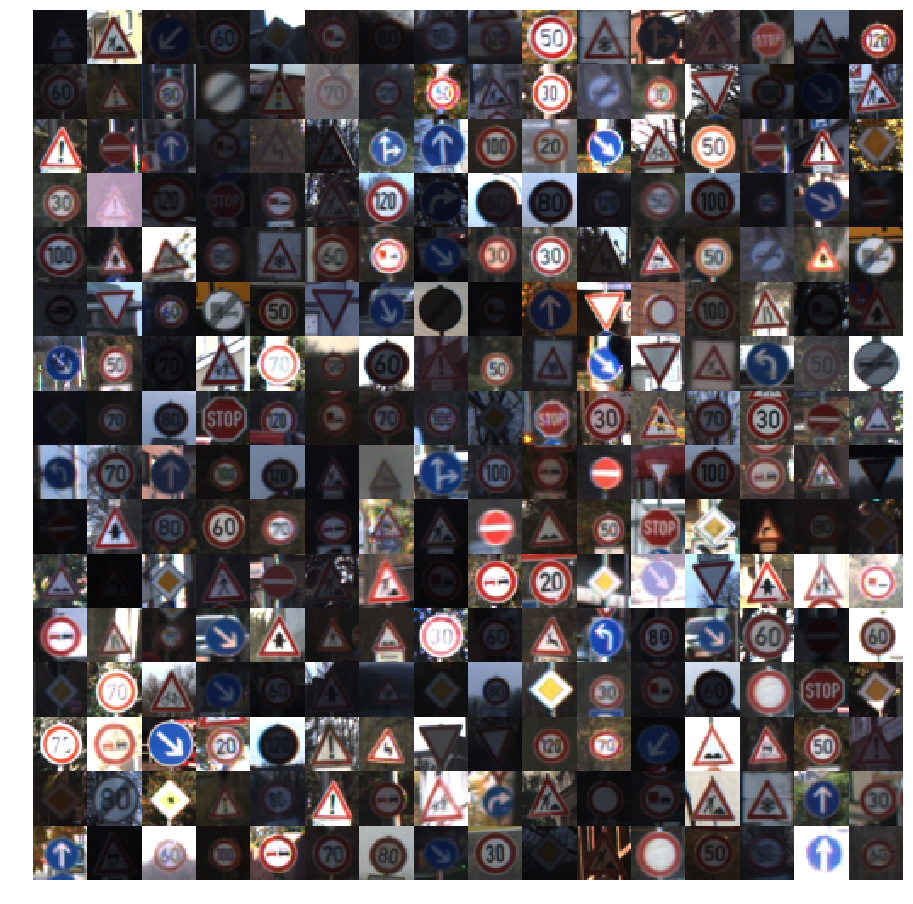

In [5]:
# Generate a mosaic image consisting of training set samples:
draw_image_mosaic(X_train, conf.exploratory_analysis_mosaic_size)

#### Label Distribution by Subsets

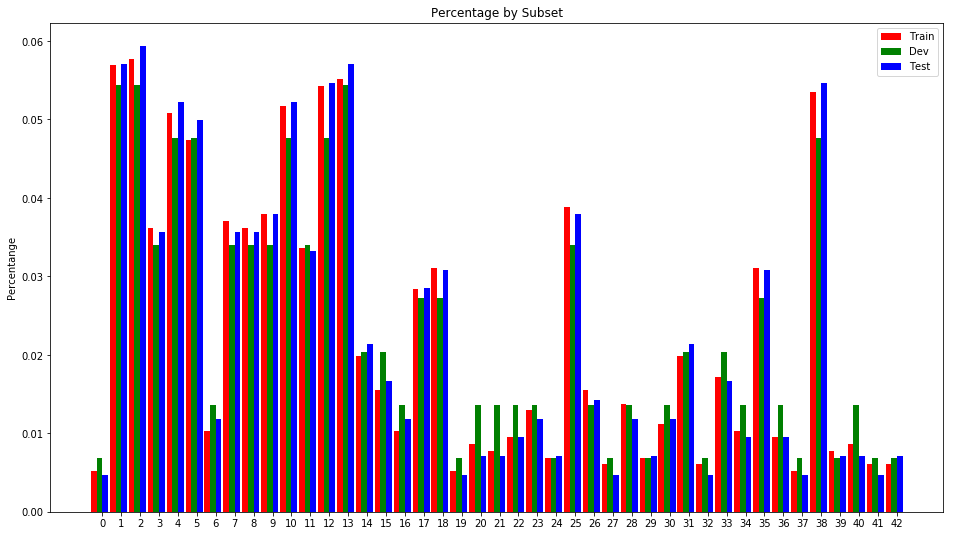

In [6]:
# Draw label distribution by subsets:
draw_label_distributions(
    np.vstack(
        [np.bincount(y_train), np.bincount(y_valid), np.bincount(y_test)]
    ),
    dataset.N_CLASSES
)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set

***

The whole preprocessing procedure goes as follows:
1. Convert image to YUV space
2. Equalize histogram on Y channel component
3. Standarize each image (done in model TrafficSignNet using Tensorflow's utility)

In [7]:
# Preprocessing step 1 & 2: 
preprocessor = Preprocessor()

X_train_transformed = preprocessor.transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)

In [8]:
# Generate more data to feed the network
from keras.preprocessing.image import ImageDataGenerator

image_data_generator = ImageDataGenerator(
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    zoom_range = 0.25,
    fill_mode='nearest'
)

Using TensorFlow backend.


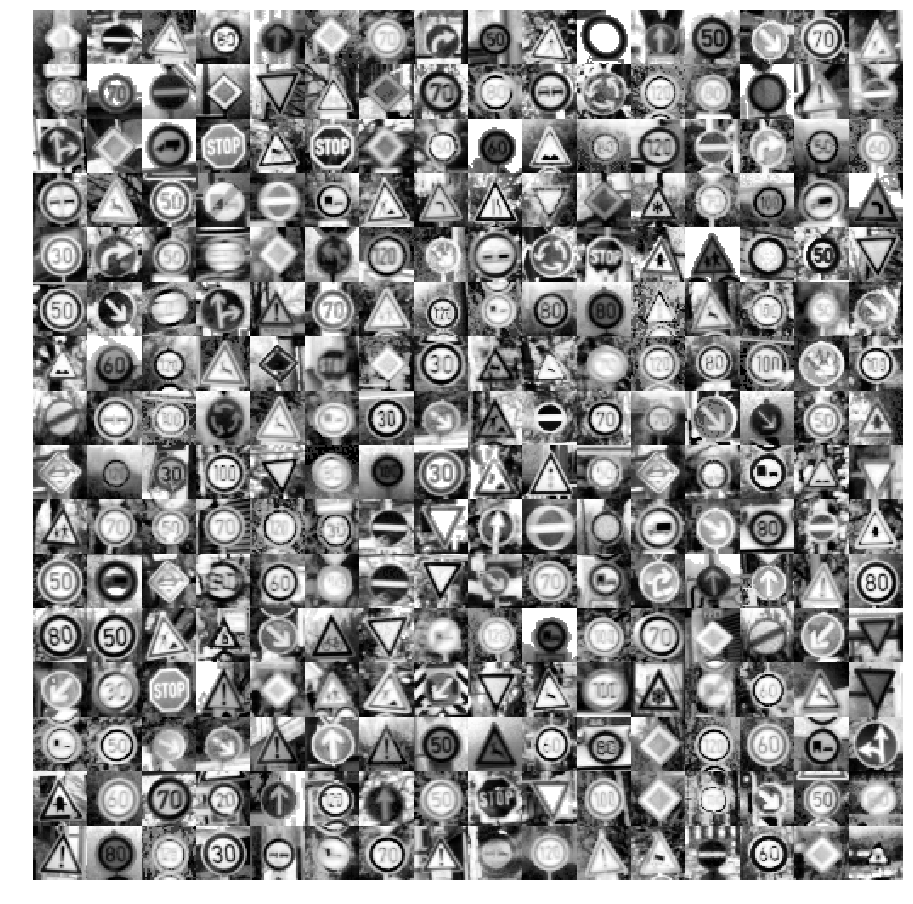

In [9]:
# Visualize again:
draw_image_mosaic(X_train_transformed, conf.exploratory_analysis_mosaic_size)

### Build the Network

***


#### Step 1: Define Paramaters for the Model

In [10]:
M_SAMPLES, H, W, C = X_train_transformed.shape
N_CLASSES = dataset.N_CLASSES

# Piecewise constant:
BOUNDARIES = [
    20000, 40000, 60000
]
LEARNING_RATES = [
    1e-3, 1e-4, 1e-5, 1e-6
]
# Exponential decay:
'''
INITIAL_LEARNING_RATE = 0.001
DECAY_STEPS = 25
DECAY_RATE = 1/10
'''

BATCH_SIZE = 512
SKIP_STEP = 2000
MAX_ITERS = 80000

KEEP_PROB = 0.5

#### Step 2: Create Placeholders for Features and Labels

In [11]:
with tf.name_scope('input'):
    X = tf.placeholder(tf.float32, [None, H, W, C], name="X")
    y = tf.placeholder(tf.int64, [None], name="y")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

#### Step 3: Create Network Architecture

In [12]:
with tf.variable_scope('standardize'):
    X_standardized = tf.map_fn(
        lambda x: tf.image.per_image_standardization(x), 
        X
    )
    
with tf.variable_scope('conv1'):
    conv1 = layers.conv2d(
        X_standardized, 
        32, 5, 1, 
        weights_initializer=layers.variance_scaling_initializer(),
        activation_fn=tf.nn.relu, 
        padding='SAME'
    )

with tf.variable_scope('pool1'):
    pool1 = tf.nn.max_pool(
        conv1, 
        ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
        padding='SAME'
    )

with tf.variable_scope('conv2'):
    conv2 = layers.conv2d(
        pool1, 
        64, 5, 1, 
        weights_initializer=layers.variance_scaling_initializer(),
        activation_fn=tf.nn.relu, 
        padding='SAME'
    )

with tf.variable_scope('pool2'):
    pool2 = tf.nn.max_pool(
        conv2, 
        ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
        padding='SAME'
    )

with tf.variable_scope('flattened'):
    flattened = layers.flatten(pool2)    
    
with tf.variable_scope('fc1'):    
    fc1 = layers.fully_connected(
        flattened, 1024, 
        weights_initializer=layers.variance_scaling_initializer(),
        activation_fn=tf.nn.relu
    )

with tf.variable_scope('fc2'): 
    fc2 = layers.fully_connected(
        fc1, 512, 
        weights_initializer=layers.variance_scaling_initializer(),
        activation_fn=tf.nn.relu
    )    

with tf.variable_scope('dropout'): 
    dropped = layers.dropout(
        fc2, 
        KEEP_PROB, 
        is_training=is_training
    ) 

with tf.variable_scope('logits') as scope:
    logits = layers.fully_connected(dropped, N_CLASSES, tf.identity)

#### Step 4: Set Up Optimization

In [13]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, 
        logits=logits
    )
    loss = tf.reduce_mean(cross_entropy)

with tf.name_scope('optimization'):
    # Learning rate scheduling:
    global_step = tf.Variable(
        0, dtype=tf.int32, trainable=False
    )
    # Piecewise constant:
    learning_rate = tf.train.piecewise_constant(
        global_step, 
        BOUNDARIES, 
        LEARNING_RATES
    )
    # Exponential decay:
    '''
    learning_rate = tf.train.exponential_decay(
        INITIAL_LEARNING_RATE, 
        global_step,
        DECAY_STEPS, 
        DECAY_RATE
    )
    '''
    # Adam optimizer:
    optimizer = tf.train.AdamOptimizer(
        learning_rate
    ).minimize(
        loss, 
        global_step=global_step
    )

with tf.name_scope('evaluation'):
    accuracy = tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(logits, 1), y), 
            tf.float32
        )
    )

#### Step 5: Set Up Monitors

In [14]:
logdir = join(
    conf.model_logdir, 
    "run-{}".format(
        datetime.utcnow().strftime("%Y%m%d%H%M%S")
    )
)

with tf.name_scope('logs'):
    train_summary = tf.summary.scalar('loss', loss)
    valid_summary = tf.summary.scalar("valid_accuracy", accuracy)

logger = tf.summary.FileWriter(
    logdir, 
    tf.get_default_graph()
)


saver = tf.train.Saver()

#### Step 6: Model Execution

In [ ]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # Whether pre-trained network exists:
    latest_checkpoint = tf.train.get_checkpoint_state(
        dirname(conf.model_checkpoints)
    )
    # If that checkpoint exists, restore from checkpoint
    if latest_checkpoint and latest_checkpoint.model_checkpoint_path:
        saver.restore(sess, latest_checkpoint.model_checkpoint_path)
        print("Load pre-trained network")
    # Else initialize all variables:
    else:
        init.run()
        print("Start from scratch")
        
    # Initialize stats:
    start_time = time.time()
    total_loss = 0.0
    INIT_ITERS = global_step.eval()

    # Current mini-batch:
    for X_batch, y_batch in image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE):
        # Iteration index:
        iter_index = global_step.eval() + 1
        
        # Stop training when reaching max. num. of iterations:
        if iter_index > MAX_ITERS + INIT_ITERS:
            break
            
        # Train:
        _, loss_batch = sess.run(
            [optimizer, loss], 
            feed_dict = {
                X: X_batch, 
                y: y_batch,
                is_training: True
            }
        ) 
            
        total_loss += loss_batch
        
        if iter_index % SKIP_STEP == 0:
            # Add to log:
            logger.add_summary(
                train_summary.eval(
                    feed_dict = {
                        X: X_batch, 
                        y: y_batch,
                        is_training: False
                    }
                ), 
                global_step = iter_index
            )
            logger.add_summary(
                valid_summary.eval(
                    feed_dict = {
                        X: X_valid, 
                        y: y_valid,
                        is_training: False
                    }
                ), 
                global_step = iter_index
            )
            print(
                "[Performance @ step {}]: {:2.4f}".format(
                    iter_index, 
                    total_loss / SKIP_STEP
                )
            )
            total_loss = 0.0
            saver.save(sess, conf.model_checkpoints.format(iter_index))
    
    saver.save(sess, conf.model_checkpoints.format("final"))
    
    print("Optimization Finished!")
    print("Total time: {0} seconds".format(time.time() - start_time))

logger.close()

### Evaluate Final Model on Training, Validation and Test Datasets

In [15]:
X_test_transformed = preprocessor.transform(X_test)

with tf.Session() as sess:
    saver.restore(sess, conf.model_checkpoints.format("final"))

    # Training set:
    NUM_BATCHES = int(np.ceil(M_SAMPLES / BATCH_SIZE))
    train_accuracy = 0.0
    for batch in range(NUM_BATCHES):
        X_train_transformed_batch = X_train_transformed[batch*BATCH_SIZE: (batch + 1)*BATCH_SIZE]
        y_train_batch = y_train[batch*BATCH_SIZE: (batch + 1)*BATCH_SIZE]
        train_accuracy_batch = accuracy.eval(
            feed_dict = {
                X: X_train_transformed_batch,
                y: y_train_batch,
                is_training: False
            }
        )
        train_accuracy += len(X_train_transformed_batch) * train_accuracy_batch
    train_accuracy /= M_SAMPLES
    
    # Valid set:
    valid_accuracy = accuracy.eval(
        feed_dict = {
            X: X_valid_transformed,
            y: y_valid,
            is_training: False
        }
    )
    # Test set:
    test_accuracy = accuracy.eval(
        feed_dict = {
            X: X_test_transformed,
            y: y_test,
            is_training: False
        }
    )
    
print("[Train Accuracy]: {:3.2f}".format(100*train_accuracy))     
print("[Valid Accuracy]: {:3.2f}".format(100*valid_accuracy))    
print("[Test Accuracy]: {:3.2f}".format(100*test_accuracy))

[Train Accuracy]: 100.00
[Valid Accuracy]: 98.03
[Test Accuracy]: 96.10


## Step 3: Test a Model on New Images

---

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Set Up Session

In [16]:
import glob
import cv2

### Load and Output the Images

In [17]:
# Initialize:
X_test_web = []

# Load from disk:
for web_image_filename in sorted(glob.glob(conf.web_images_dir)):
    x_test_web = cv2.imread(web_image_filename)
    x_test_web = cv2.cvtColor(
        cv2.resize(x_test_web, (32, 32)),
        cv2.COLOR_BGR2RGB
    )
    X_test_web.append(x_test_web)
    
# Convert to numpy ndarray:
X_test_web = np.array(X_test_web)

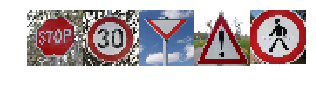

In [18]:
# Initialize canvas:
size = len(X_test_web)
plt.figure(figsize=(size, size))
# Turn off axes:
plt.gca().set_axis_off()
# Draw
plt.imshow(np.hstack(X_test_web))
plt.show()

### Predict the Sign Type for Each Image

In [19]:
# Preprocessing:
X_test_web_transformed = preprocessor.transform(X_test_web)

# Predict:
with tf.Session() as sess:
    # Load model:
    saver.restore(sess, conf.model_checkpoints.format("final"))
    
    # Logits:
    logits_val, (top_5_probs_val, top_5_idxs_val) = sess.run(
        [
            logits, 
            tf.nn.top_k(
                tf.nn.softmax(logits),
                k = 5
            )
        ],
        feed_dict = {
            X: X_test_web_transformed,
            is_training: False
        }
    )
    
# Labels:
labels = np.argmax(logits_val, axis = 1)

# Label names:
signs = dataset.get_label_name(labels)

# Top 5 label names:
top_5_signs = [dataset.get_label_name(labels) for labels in top_5_idxs_val]

print(signs)

['Stop' 'Speed limit (30km/h)' 'Yield' 'General caution'
 'Speed limit (70km/h)']


### Analyze Performance

From the above prediction results we know the accuracy is **80%**, since the model made 3 correct predictions out of 5.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

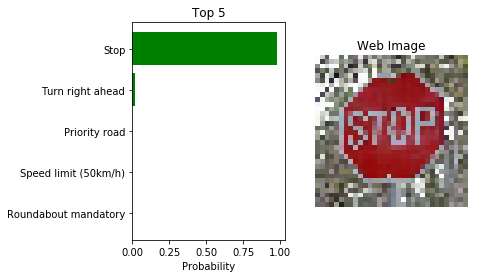

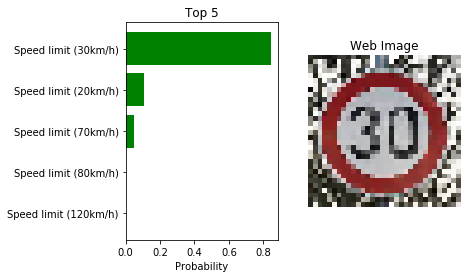

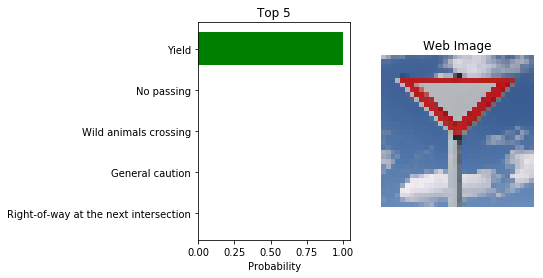

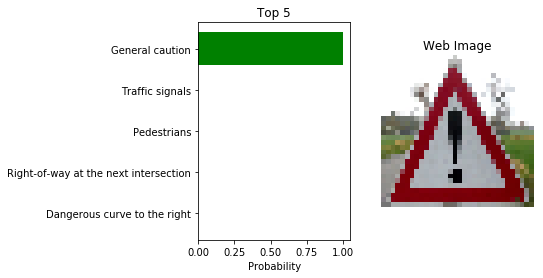

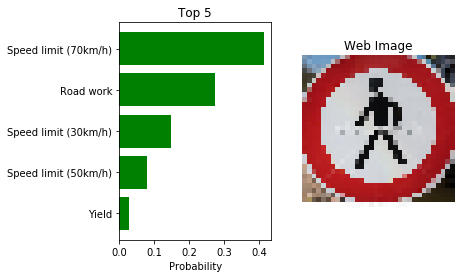

In [20]:
for (image, labels, probs) in zip(
    X_test_web,
    top_5_signs,
    top_5_probs_val
):
    draw_top_k(image, labels, probs)

---

## Step 4 Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.